# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [5]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2015-05-15/data_eval_new/"
file_name = "int_norm_20150515_bgd_corr.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [6]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [7]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [8]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

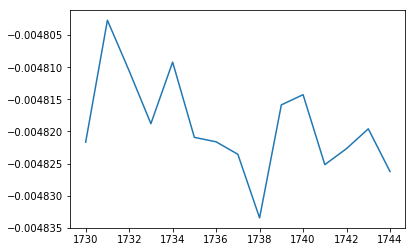

In [9]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

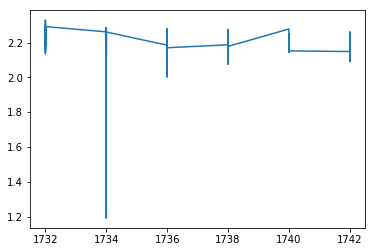

In [10]:
# Check Signals
column = "122"
sample = "SPEX 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

In [11]:
df_mean(signals[signals["118"] < 0.05])

,Filenumber,Sample,110,111,112,113,114,115,116,117,...,120_2,121_2,122_2,123_2,124_2,125_2,126_2,127_2,129_2,131_2
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-15 15:37:00,1730,blank sol,0.000118,0.000082,0.000276,0.000069,0.000224,0.000080,0.002265,0.001195,...,0.005844,0.003046,0.000749,0.002348,0.000988,0.000031,0.000121,0.171444,0.012608,0.010369
2015-05-15 18:27:00,1744,blank sol,0.000094,0.000087,0.000244,0.000082,0.000211,0.000065,0.002194,0.001151,...,0.005983,0.001504,0.000745,0.001159,0.000997,0.000023,0.000112,0.158658,0.012339,0.010148


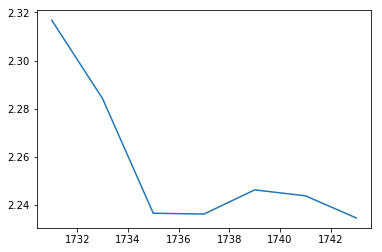

In [12]:
# Check Signals - mean
column = "122"
sample = "NIST 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

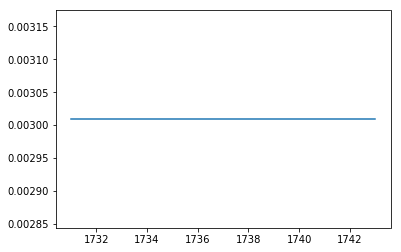

In [13]:
# Check background 
column = "118"
sample = "NIST 100ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [14]:
background_mean = df_mean(background)

In [15]:
# Create Dataframe for signals_bgd corr
signals["Te/Sn"] = (signals["126_2"]/18.8066)/(signals["118"]/24.223)
signals["Cd/Sn"] = (signals["111"]/12.9447)/(signals["118"]/24.223)

In [16]:
signals_mean = signals.groupby("Filenumber").agg("mean")

# Outlier rejection

In [79]:
bgd_method = 'bgd_outlier_corr' #'no_bgd_corr'
norm_ratio = "r_118_120"
interf_corr = "Te125_Xe129_corr"

In [80]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [81]:
column = "124/120"
sample = "NIST 100ppb"

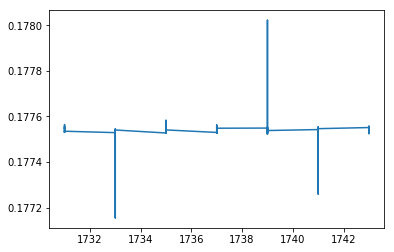

In [82]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [83]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [84]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,,,
2015-05-15 15:48:00,NIST 100ppb,2,1,1731,0.029834,0.020195,0.010360,0.446001,0.235307,NaN,0.263450,0.142082,0.177549
2015-05-15 15:48:00,NIST 100ppb,2,2,1731,0.029834,0.020198,0.010360,0.445973,0.235291,0.742935,0.263442,0.142081,0.177555
2015-05-15 15:48:00,NIST 100ppb,2,3,1731,0.029826,NaN,0.010359,0.445976,0.235298,0.742935,0.263441,0.142078,0.177554
2015-05-15 15:48:00,NIST 100ppb,2,4,1731,0.029835,0.020204,0.010360,0.446020,0.235322,0.742935,0.263451,0.142068,0.177530
2015-05-15 15:48:00,NIST 100ppb,2,5,1731,0.029833,0.020197,0.010363,0.446040,0.235311,NaN,0.263456,0.142074,0.177546
2015-05-15 15:48:00,NIST 100ppb,2,6,1731,0.029828,0.020198,0.010361,0.446008,0.235313,NaN,0.263450,0.142074,0.177552
2015-05-15 15:48:00,NIST 100ppb,2,7,1731,0.029824,0.020196,0.010363,0.445991,0.235309,0.742935,0.263453,0.142079,0.177565
2015-05-15 15:48:00,NIST 100ppb,2,8,1731,0.029825,0.020196,0.010358,0.445979,0.235299,0.742935,0.263432,0.142079,0.177540
2015-05-15 15:48:00,NIST 100ppb,2,9,1731,0.029832,0.020198,0.010358,0.446013,0.235305,NaN,0.263448,0.142083,0.177540


In [85]:
df_outlier_int[df_outlier_int[column].notnull()][column]

Filenumber  Date               
1732        2015-05-15 16:00:00    0.176314
1733        2015-05-15 16:12:00    0.177155
1734        2015-05-15 16:24:00    0.177582
            2015-05-15 16:24:00    0.177590
            2015-05-15 16:24:00    0.177582
1735        2015-05-15 16:36:00    0.177583
1736        2015-05-15 16:49:00    0.177621
1739        2015-05-15 17:26:00    0.178022
1741        2015-05-15 17:50:00    0.177260
1742        2015-05-15 18:03:00    0.178094
Name: 124/120, dtype: float64

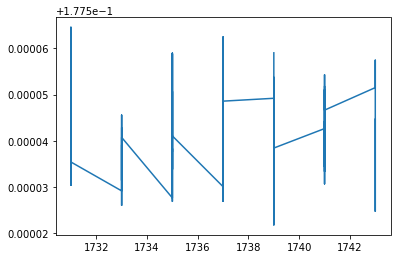

In [86]:
# Check sample measurements
df = df_outlier_rej_int

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [87]:
df[df["Sample"] == sample][column].std()

9.119921425919626e-06

In [88]:
df_outlier_rej_int["Cd/Sn"] = signals[signals["Sample"] != "blank sol"]["Cd/Sn"]
df_outlier_rej_int["Te/Sn"] = signals[signals["Sample"] != "blank sol"]["Te/Sn"]

In [89]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

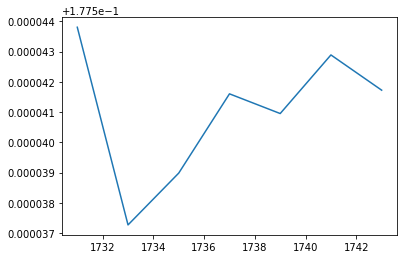

In [90]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [91]:
data_mean_int

,Filenumber,Sample,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Cd/Sn,Te/Sn
Date,,,,,,,,,,,,,
2015-05-15 15:48:00,1731,NIST 100ppb,0.029830,0.020197,0.010361,0.446008,0.235309,0.742935,0.263446,0.142078,0.177544,0.000012,0.000016
2015-05-15 16:00:00,1732,SPEX 100ppb,0.029827,0.020192,0.010369,0.446012,0.235311,0.742935,0.263443,0.142074,0.177532,0.000016,0.000017
2015-05-15 16:12:00,1733,NIST 100ppb,0.029829,0.020194,0.010361,0.446020,0.235312,0.742935,0.263446,0.142075,0.177537,0.000014,0.000018
2015-05-15 16:24:00,1734,SPEX 100ppb,0.029827,0.020194,0.010368,0.446027,0.235309,0.742935,0.263452,0.142079,0.177537,0.000016,0.000017
2015-05-15 16:36:00,1735,NIST 100ppb,0.029831,0.020195,0.010360,0.446015,0.235310,0.742935,0.263446,0.142078,0.177539,0.000013,0.000020
2015-05-15 16:49:00,1736,SPEX 100ppb,0.029825,0.020192,0.010368,0.446022,0.235311,0.742935,0.263447,0.142073,0.177534,0.000017,0.000018
2015-05-15 17:01:00,1737,NIST 100ppb,0.029827,0.020192,0.010361,0.446021,0.235311,0.742935,0.263447,0.142077,0.177542,0.000017,0.000019
2015-05-15 17:14:00,1738,SPEX 100ppb,0.029827,0.020194,0.010368,0.446023,0.235306,0.742935,0.263445,0.142077,0.177540,0.000016,0.000019
2015-05-15 17:26:00,1739,NIST 100ppb,0.029832,0.020196,0.010360,0.446028,0.235311,0.742935,0.263447,0.142076,0.177541,0.000012,0.000015


In [92]:
date_list = []
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [93]:
drop_sum = []

In [94]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [95]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [96]:
data_mean_int_sum

112/120                   114/120                   115/120  \
                 mean       SD2 count      mean       SD2 count      mean   
Sample                                                                      
NIST 100ppb  0.029829  0.000003     7  0.020194  0.000004     7  0.010360   
SPEX 100ppb  0.029827  0.000003     6  0.020194  0.000004     6  0.010368   

                              116/120  ...  122/120   124/120                  \
                  SD2 count      mean  ...    count      mean       SD2 count   
Sample                                 ...                                      
NIST 100ppb  0.000001     7  0.446020  ...        7  0.177541  0.000004     7   
SPEX 100ppb  0.000001     6  0.446022  ...        6  0.177536  0.000005     6   

                Cd/Sn                     Te/Sn                  
                 mean       SD2 count      mean       SD2 count  
Sample                                                           
NIST 100ppb  0.000014  0.000004     7  0.000017  0.000004     7  
SPEX 100ppb  0.000015  0.000003     6  0.000018  0.000003     6  

[2 rows x 33 columns]

In [97]:
date_list = []


epsilon_int_NIST = SSB(data_mean_int.drop(date_list), "NIST 100ppb", 10000)
delta_raw_NIST = SSB(data_mean_raw.drop(date_list), "NIST 100ppb", 1000)
epsilon_int_SPEX = SSB(data_mean_int.drop(date_list), "SPEX 100ppb", 10000)
delta_raw_SPEX = SSB(data_mean_raw.drop(date_list), "SPEX 100ppb", 1000)

In [98]:
epsilon_int_NIST = epsilon_int_NIST.drop(["Cd/Sn", "Te/Sn"], axis=1)
epsilon_int_SPEX = epsilon_int_SPEX.drop(["Cd/Sn", "Te/Sn"], axis=1)

In [99]:
epsilon_int_SPEX

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2015-05-15 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SPEX 100ppb
2015-05-15 16:12:00,0.0,0.687605,0.709671,-7.140379,0.020278,0.076653,2.220446e-12,-0.056039,-0.103628,0.155050,NIST 100ppb
2015-05-15 16:24:00,0.0,0.131294,0.754689,0.021070,0.219431,-0.108452,2.220446e-12,0.259127,0.330442,0.181787,SPEX 100ppb
2015-05-15 16:36:00,0.0,1.516260,0.952837,-7.586105,-0.209954,0.028474,0.000000e+00,-0.127087,0.129115,0.194076,NIST 100ppb
2015-05-15 16:49:00,0.0,-0.466524,-0.639406,-0.193320,-0.059731,0.159639,-1.110223e-12,-0.062851,-0.302479,-0.218530,SPEX 100ppb
2015-05-15 17:01:00,0.0,0.320678,-0.706806,-6.880382,-0.034166,0.123588,0.000000e+00,0.047716,0.125774,0.247452,NIST 100ppb
2015-05-15 17:14:00,0.0,-0.044102,0.138122,-0.530241,-0.024513,-0.260777,0.000000e+00,-0.110864,0.218038,0.301055,SPEX 100ppb
2015-05-15 17:26:00,0.0,1.353623,0.920835,-7.771294,0.071250,0.078581,0.000000e+00,-0.014762,0.038631,0.198917,NIST 100ppb
2015-05-15 17:38:00,0.0,0.023830,-0.692479,0.290205,0.081165,0.169530,0.000000e+00,0.168479,-0.123917,-0.179110,SPEX 100ppb


In [100]:

date_list = []

epsilon_int_NIST = epsilon_int_NIST.drop(date_list)
delta_raw_NIST = delta_raw_NIST.drop(date_list)

In [101]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -5) & (df["Filenumber"] <= 5)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [102]:
epsilon_int_NIST = epsilon_process(epsilon_int_NIST)
delta_raw_NIST = epsilon_process(delta_raw_NIST)
epsilon_int_SPEX = epsilon_process(epsilon_int_SPEX)
delta_raw_SPEX = epsilon_process(delta_raw_SPEX)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [103]:
epsilon_int_NIST

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2015-05-15 16:00:00,1732,-0.702194,-1.794984,7.632014,-0.047067,0.042437,-1.110223e-12,-0.106993,-0.131725,-0.458928,SPEX 100ppb
2015-05-15 16:12:00,1733,-0.363265,-0.829688,0.719770,0.198047,0.088953,2.220446e-12,0.002056,-0.186505,-0.232505,NIST 100ppb
2015-05-15 16:24:00,1734,-1.036165,-0.453887,7.379205,0.204555,-0.106789,2.220446e-12,0.221127,0.152475,-0.083669,SPEX 100ppb
2015-05-15 16:36:00,1735,0.844430,1.009028,-0.662242,-0.123163,-0.046054,0.000000e+00,-0.024789,0.132020,-0.025549,NIST 100ppb
2015-05-15 16:49:00,1736,-1.151630,-0.442725,7.141754,0.092196,0.003788,-1.110223e-12,0.008260,-0.278682,-0.330023,SPEX 100ppb
2015-05-15 17:01:00,1737,-1.369385,-1.894092,0.437120,-0.006936,0.019489,-1.110223e-12,0.031783,-0.000323,0.092214,NIST 100ppb
2015-05-15 17:14:00,1738,-0.859143,-0.037972,7.065895,-0.030798,-0.231472,0.000000e+00,-0.071909,0.026815,-0.072658,SPEX 100ppb
2015-05-15 17:26:00,1739,1.241925,1.744822,0.185057,0.089038,0.037242,0.000000e+00,0.004303,-0.083663,-0.072980,NIST 100ppb
2015-05-15 17:38:00,1740,-0.606061,-0.059019,8.674036,-0.022662,0.111555,0.000000e+00,0.105736,-0.187739,-0.398146,SPEX 100ppb


In [104]:
epsilon_NIST_sum = np.round(epsilon_int_NIST.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_NIST_sum = np.round(delta_raw_NIST.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_SPEX_sum = np.round(epsilon_int_SPEX.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_SPEX_sum = np.round(delta_raw_SPEX.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_NIST_sum.append(epsilon_SPEX_sum)
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_NIST_sum.append(delta_raw_SPEX_sum)
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [105]:
epsilon_sum_all

112/120              114/120              115/120               \
               mean    SD2 count    mean    SD2 count    mean    SD2 count   
Sample                                                                       
NIST 100ppb   0.010  2.086     5  -0.149  2.971     5  -0.014  1.322     5   
SPEX 100ppb  -0.636  1.221     6  -0.085  2.649     6   7.838  1.723     6   
NIST 100ppb   0.752  1.376     5   0.076  2.228     5  -7.730  1.862     5   
SPEX 100ppb  -0.089  0.524     4  -0.110  1.380     4  -0.103  0.693     4   

            116/120  ...  118/120 119/120              122/120               \
               mean  ...    count    mean    SD2 count    mean    SD2 count   
Sample               ...                                                      
NIST 100ppb   0.035  ...        5  -0.006  0.057     5  -0.015  0.250     5   
SPEX 100ppb   0.021  ...        6   0.011  0.260     6  -0.099  0.317     6   
NIST 100ppb  -0.019  ...        5  -0.036  0.127     5   0.081  0.240     5   
SPEX 100ppb   0.054  ...        4   0.063  0.357     4   0.031  0.589     4   

            124/120               
               mean    SD2 count  
Sample                            
NIST 100ppb  -0.030  0.268     5  
SPEX 100ppb  -0.282  0.329     6  
NIST 100ppb   0.243  0.207     5  
SPEX 100ppb   0.021  0.519     4  

[4 rows x 27 columns]

In [257]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_NIST.append(epsilon_int_SPEX), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_NIST.append(delta_raw_SPEX), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [258]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

NameError: name 'hdf5_sum_file' is not defined

# Raw data to xls file

In [44]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [45]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
#background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [106]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_bgd_new.xlsx', engine='xlsxwriter')


In [107]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_NIST.append(epsilon_int_SPEX).to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_NIST.append(delta_raw_SPEX).to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [108]:
writer_orig.save()

In [111]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [109]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')